# Tarea 1 Grupo


Contextualizar un poco (archivos secundarios y despues el principal con las respuestas a las preguntas)


## Archivos secundarios


In [2]:
from random import seed, random
from numpy.random import poisson, negative_binomial
from numpy.random import seed as npseed



def simulation_parameters(total, delta_t,s):
    seed(s)
    npseed(s)
    r_p = {i: poisson(15) for i in range(total)} # El tiempo de recuperacion
    c_p = {i: min(r_p[i], negative_binomial(6,0.5)) for i in range(total)} # Tiempo en que se da cuenta
    contagios = {t: {i: random() for i in range(total)} for t in range(delta_t + 1)}

    return r_p, c_p, contagios
### es ineficiente, porque nos da el numero de probabilidad de que se contagie en cada día aunque no se reunan (son numeros inuyiles)
## que no es tan importante, pero lo tuvimos en cuenta para el orden
##y nos generaria problemas

Aca explicas Personas importante exlicar sus atributos  y los metodos pasar dia y contacto

In [3]:
class Persona:
    def __init__(self,id,probabilidad_contagio):
        self._id = id #esto es por bonito nada más, para identificar a cada persona
        self._probabilidad_contagio = probabilidad_contagio #probabilidad de contagio inicial de cada persona
        self.estado = "S" # S: sano; A asintomatico; E enfermo ; M muerto ; R recuperado
        self._dias_recuperacion = 0 #cuenta regresiva a recuperacion, se inicializan en 0 porque al principio no saben si tienen la enfermedad
        self._dias_sintomas = 0 #cuenta regresiva a presentar sintomas
    @property
    def dias_recuperacion(self):  # manejan los cambios de estado (todas las propertys @)
        return self._dias_recuperacion
    @dias_recuperacion.setter
    def dias_recuperacion(self, a):
        if(a <= 0):
            self._dias_recuperacion = 0
            self.estado = "R"
        self._dias_recuperacion = a
    @property
    def dias_sintomas(self):
        return self._dias_sintomas
    @dias_sintomas.setter
    def dias_sintomas(self, a):    #dias hasta que empiezan a tener sintomas
        if(a <= 0):
            self._dias_sintomas = 0
            self.estado = "E"                    #usamos clases por facilidad de modificar y clasificar estados, agregar todo tipo de informacion
        self._dias_sintomas = a
    def contacto(self,dado,dias_recuperacion,dias_sintomas):        #dado es para ver si se contagio o no, dado el numero del dado
        if self.estado == "S" and dado <= self._probabilidad_contagio:
            self.estado = "A"
            self._dias_recuperacion = dias_recuperacion
            self._dias_sintomas = min(dias_sintomas, dias_recuperacion)

    def pasar_dia (self):
        if self.estado in ["A","E"]:                 #solo afecta si estas asintomatico o enfermo, sino estas sano o muerto, no afecta
            if self.estado == "A":
                self.dias_sintomas -= 1
            self.dias_recuperacion -= 1

    def __repr__(self):                     #los dos para que se vea bonito
        return self.estado+str(self._id)
    def __str__(self):
        if self.estado == "S":
            return f"Soy {self._id}, estoy Sano, P contagio {self._probabilidad_contagio}"
        if self.estado == "A":
            return f"Soy {self._id}, estoy Asintomatico,sintomas:{self._dias_sintomas}, recuperacion {self._dias_recuperacion}"
        if self.estado == "E":
            return f"Soy {self._id}, estoy Enfermo, recuperacion {self._dias_recuperacion}"
        if self.estado == "R":
            return f"Soy {self._id}, estoy Recuperado "

In [4]:
#Codigo_Graficos.py
import matplotlib.pyplot as plt
import numpy as np


def graficar_infectados(diccionario):
    cantidad_casos_totales = diccionario["it"]   #it es infectados totales
    cantidad_casos_recuperados = diccionario["r"] #recueprados
    cantidad_casos_actuales = diccionario["i"] #infectados actuales
    x = diccionario["t"]   # dia
    plt.plot(x, cantidad_casos_actuales,label= 'casos actuales')
    plt.plot(x, cantidad_casos_recuperados, label= 'casos recuperados')
    plt.plot(x, cantidad_casos_totales, label= 'casos totales')
    plt.ylabel('Cantidad de infectados')
    plt.xlabel('Días')
    plt.title("Infectados en función del tiempo")

    plt.legend(loc=0)
    plt.savefig("grafico_infectados.png")
    mostrar=plt.show()
    return mostrar

# Main script 
## Librerias Y VERBOSIDAD
explicacion de librerias

Las comentadas no son necesarias en jupyther notebook porque ya se ejecutaron las cendas
Si verboso es true se imprimiran cosas en la consola 

In [5]:
from collections import defaultdict          #para ordenarse en los momentos de reunion
#from personas import Persona                #clase creada, mencionada en la celda anterior
#from simulation_parameters import simulation_parameters    #para llamar a la funcion simulatio_parameters
#from Codigo_Graficos import graficar_infectados            #para llamar a la funcion
import os  #https://stackoverflow.com/questions/7165749/open-file-in-a-relative-location-in-python
import re  #https://stackoverflow.com/questions/1249388/removing-all-non-numeric-characters-from-string-in-python
import copy  #https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
import time  #medir los tiempos tiempos de simulacion, para medir la eficienci
VERBOSIDAD = 1 # 0 es no imprimir nada, 1 minimo (recomendado), 2 es imprimir lo basico  , 3 es imprimir los detalles

explicación (1.1 Nuestro grafo..)

In [6]:
#archivo main.py
def crear_grafo ( personas, reuniones):
    """ Crea un default diccionario donde las llaves son los dias y los elemntos son una
    lista con los sets con los id de las personas que se juntaron """
    data_reuniones = defaultdict(list)
    with open (reuniones) as file:    #abrir archivo
        linea = file.__next__()       #nos da la unica linea del archivo
    inter = linea.split("({")         #lee la base de datos

    for i in range(1,len(inter)):
        parcial = set(map(int,inter[i].split("}")[0].split(", ")))    #usamos sets porque es mas eficiente la busqueda, facilita todo
        dia = int(re.sub("[^0-9]", "",inter[i].split("}")[1] ))       
        data_reuniones[dia].append(parcial)
    #reuniones son los arcos
    #cantidad de dia desde la infeccion que su estado de Enfermos con Sintomas
    """ Crea un diccionario donde las llaves son las id y los elementos son instancias de la clase personas"""
    data_personas = dict()    #no es defaultdict porque no tiene sentido preguntar por personas que no existen (gigo)
    with open (personas) as file:   #fue un diccionario en vez de una lista, porque al principio estaba  desordenado y ahora no, pero ya esta hecho
        linea = file.__next__().strip("{}")
    inter = linea.split(", ")
    for i in inter:
        persona = i.split(":")
        id = int(persona[0])
        data_personas[id]= Persona(id,float(persona[1]))   #aca se guardo en cada nodo, una instancia para cada persona
    return (data_personas,data_reuniones)

# aca va el codigo de la funcion
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)  

Aca explicas determinar contagiados importante notar la eficiencia de los sets (esta es la pregunta 1) (hacemos sets porque es muy eficientes los metodos union e intersection y es facil revisar si algo esta dentro del set)

In [7]:
#archivo main.py

#bastante efciciente creo que el por caso seria si todas las personas se juntaran todos los dias
def determinar_contagiados(grafo, p0 ,delta_dias):
    #grafo es un grafo formado por la estructura de la funcion crear_grafo
    #p0 es in integer con el indice del paciente 0
    #dia_final número de días transcurridos
    posibles = set()
    posibles.add(p0)
    data_reuniones = grafo[1]
    for t in range (0,delta_dias+1):
        if VERBOSIDAD>1:
            print(f"POSIBLES al principio del DIA {t}",posibles)
        for reunion in data_reuniones[t]:
            if posibles.intersection(reunion):
                posibles = posibles.union(reunion)
                if VERBOSIDAD > 3:
                    print(F"Reunion infectada DIA{t}:",reunion, "culpables:",posibles.intersection(reunion))
    if VERBOSIDAD > 1:
        print(F"\n POSIBLES al final del dia {t}",posibles)
    return posibles

#acá se debería correr la función
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 7 # Cantidad de dias
determinar_contagiados(grafo,p0,delta_dias)


{0,
 5,
 9,
 11,
 14,
 20,
 22,
 24,
 25,
 26,
 27,
 29,
 32,
 33,
 34,
 35,
 37,
 45,
 48,
 49,
 50,
 51,
 54,
 56,
 58,
 60,
 64,
 65,
 69,
 71,
 72,
 73,
 77,
 78,
 80,
 83,
 84,
 86,
 89,
 92,
 95,
 96,
 98,
 100,
 102,
 106,
 108,
 109,
 115,
 118,
 121,
 130,
 131,
 133,
 134,
 142,
 147,
 148,
 157,
 158,
 160,
 161,
 163,
 166,
 168,
 169,
 173,
 174,
 175,
 178,
 184,
 187,
 188,
 189,
 193,
 194,
 195,
 196,
 199,
 202,
 203,
 204,
 208,
 213,
 215,
 219,
 228,
 229,
 231,
 232,
 236,
 239,
 241,
 243,
 246,
 250,
 253,
 256,
 257,
 258,
 260,
 264,
 266,
 268,
 272,
 273,
 275,
 276,
 277,
 278,
 283,
 285,
 286,
 288,
 290,
 293,
 296,
 300,
 301,
 302,
 303,
 304,
 307,
 308,
 313,
 318,
 326,
 329,
 331,
 335,
 336,
 340,
 344,
 345,
 346,
 347,
 348,
 350,
 353,
 356,
 362,
 365,
 368,
 369,
 371,
 372,
 374,
 375,
 378,
 379,
 387,
 390,
 391,
 392,
 395,
 396,
 397,
 400,
 404,
 405,
 406,
 410,
 411,
 412,
 414,
 421,
 422,
 425,
 426,
 427,
 428,
 431,
 433,
 434,
 4

Fin del DIA 75
Inf: 0 -Vect: 0 -Rec: 1425


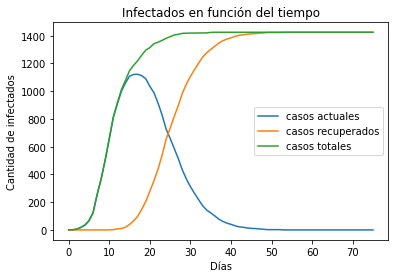

In [8]:
def simular_contagio( grafo, p0, delta_dias, s):
    #vectores = infectados actuales
    data_personas = grafo[0]          #primer elemento del grafo (los nodos)
    data_reuniones = grafo[1]          # segundo
    "Se simulan los parametros necesarios para cada persona"
    parametros = simulation_parameters(len(data_personas),delta_dias,s)
    dias_recuperacion = parametros[0]
    dias_sintomas = parametros[1]
    contagios = parametros[2]
    vectores = set()        #los que pueden contagiar
    vectores.add(p0)
    infectados = set()
    infectados.add(p0)
    recuperados = set()

    data_personas[p0].contacto(0,dias_recuperacion[p0] , dias_sintomas[p0])  ##inicilizar el tiempo para p0 con sus contadores
    datos_infectados = []
    datos_recuperados = []
    datos_it = []
    dias = []

    for t in range (0,delta_dias+1):
        if VERBOSIDAD > 1:
            print(f"Comienza DIA {t}")
            print("Inf:",len(infectados),"-Vect:",len(vectores),"-Rec:",len(recuperados))
        datos_infectados.append(len(infectados))
        datos_recuperados.append(len(recuperados))
        datos_it.append(len(recuperados)+len(infectados))     #guardando los datos de cada dia para ponerlos en el grafico
        dias.append(t)
        for reunion in data_reuniones[t]:
            culpables = vectores.intersection(reunion) #son los que infectaron la reunion, que tiene complejidad (buscar)
            if culpables:                    #si es que existen culpables, que es lo mismo que decir len(culpables)>0            
                for posible_contagiado in reunion - culpables:       # la resta es sacar los elementos iguales
                    id = posible_contagiado
                    if id not in recuperados and id not in infectados:   # si no esta en ninguno de los dos, esta sano
                        data_personas[id].contacto(contagios[t][id],dias_recuperacion[id] , dias_sintomas[id])  # ese contagios da el numero del dado,
       
        ##########################################################
        ##### VERDADERA FUENTE DE INEFICIENCIA DEL PROGRAMA ######
        ##########################################################
        # porque iteramos sobre todas las personas todos los dias O(m*n)   m:cantidad personas, n: cantidad de días
        # si queremos mejorar la eficiencia del codigo, esto es lo que hay que mejorar
        # podriamos llevar la cuenta de cambios de estado de las personas y asi tener el estado en cada momento del individuo, pero de esta forma,
        # perdemos la moldeabilidad y la escalabilidad del codigo (por ahora podría tener más caracteristicas el codigo(relaciones mas complejas,
        # mas enfermedades, muertes, entre otros factores) gracias a que los tratamos como objeto y no como una sola variable)
        infectados = set()
        vectores = set()
        recuperados = set()
        for i in range(0,len(data_personas)):                   
            data_personas[i].pasar_dia()
            if data_personas[i].estado == "A":
                vectores.add(i)
                infectados.add(i)
            elif data_personas[i].estado == "E":
                infectados.add(i)
            elif data_personas[i].estado == "R":
                recuperados.add(i)
            elif data_personas[i].estado == "S":
                pass
            else:
                print("ERROR ESTADO ANOMALO")
    if VERBOSIDAD:
        print(f"Fin del DIA {t}")
        print("Inf:",len(infectados),"-Vect:",len(vectores),"-Rec:",len(recuperados))
    return infectados,recuperados,{"t":dias,
            "i":datos_infectados,
            "it":datos_it,
            "r":datos_recuperados}

#acá se debería correr la función
VERBOSIDAD = 1
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 75 # Cantidad de dias
p0 = 33 #paciente original
delta_dias = 75 # Cantidad de dias
SEED = 6
resultados = simular_contagio( grafo, 33, delta_dias, SEED)
graficar_infectados(resultados[2])

# ADVERTENCIA: Correr esta celda puede demorar un tiempo (5 min aporx) 

In [ ]:
def probabilidad_contagio(grafo,p0,delta_dias):
    Cantidad = len(grafo[0])       #se obtiene la cantidad de personas
    SIMULACIONES = 1000
    conteos = {i: 0 for i in range(Cantidad)}      #esto crea un diccionario con las llaves siendo el id de la persona, y con todos los elementos en 0
    tiempo_simulaciones = 0                        #crea el tiempo para las simulaciones
    for s in range (0,SIMULACIONES):               #s es la semilla para poder hacer la cantidad de simulaciones requerida (1000), para tener diferentes semillas
        copia_grafo = copy.deepcopy(grafo)         # en vez de crear grafos para cada simulacion, los copiamos y los vamos sobreescribiendo
        if VERBOSIDAD:
            print("-"*45,f"SIMUACION SEMILLA: {s}","-"*45)
        t_inicio=time.time()
        infectados = simular_contagio(copia_grafo, p0, delta_dias,s)[0]   ##aca da la complejidad del algoritmo que es O(|s|*|Cantidad|)  (cada simulacion se demora lac antidad de dias asi que son lo mismo)
        tiempo_simulacion = time.time()-t_inicio
        tiempo_simulaciones += tiempo_simulacion        #autoexplicativo
        if VERBOSIDAD: # es lo mismo que if verbosidad >=1
            print(F"Tiempo de simulacion{tiempo_simulacion}")
        for i in range(Cantidad):
            if i in infectados:
                conteos[i] += 1       #en este for, se va actualizando el valor del diccionario, que nos dice cuantas veces se enfermo cada weon
    for i in range (0, Cantidad):
        conteos[i]= float(conteos[i])/float(SIMULACIONES) #ya esta hecha la division
        if conteos[i] and VERBOSIDAD > 1:
            print(f"Pasinte{i}: probabilidad: {conteos[i]}") #pos simplicidad solo printea los que son distintos de 0 
    print(f"Con {Cantidad} personas y {delta_dias} dias se demora {tiempo_simulaciones}s en hacer {SIMULACIONES} simulaciones\nPromedio de simulacion{tiempo_simulaciones/SIMULACIONES} s")
    return conteos

#acá se debería correr la función
script_dir = os.path.dirname("Informe.ipynb") #<-- absolute dir the script is in
CODIGO = 1500 #Cantidad de pacientes
personas = os.path.join(script_dir, f"Instancias/personas_{CODIGO}.txt")     #aca se crea el grafo (incluyendo las siguientes 3 lineas)
reuniones = os.path.join(script_dir, f"Instancias/reuniones_{CODIGO}.txt")
grafo = crear_grafo(personas,reuniones)
p0 = 33 #paciente original
delta_dias = 75 # Cantidad de dias
p0 = 33 #paciente original
delta_dias = 22 # Cantidad de dias
probabilidades = probabilidad_contagio(grafo,p0,delta_dias)

--------------------------------------------- SIMUACION SEMILLA: 0 ---------------------------------------------
Fin del DIA 22
Inf: 794 -Vect: 114 -Rec: 571
Tiempo de simulacion0.0962979793548584
--------------------------------------------- SIMUACION SEMILLA: 1 ---------------------------------------------
Fin del DIA 22
Inf: 953 -Vect: 180 -Rec: 366
Tiempo de simulacion0.11301302909851074
--------------------------------------------- SIMUACION SEMILLA: 2 ---------------------------------------------
Fin del DIA 22
Inf: 816 -Vect: 146 -Rec: 544
Tiempo de simulacion0.09331202507019043
--------------------------------------------- SIMUACION SEMILLA: 3 ---------------------------------------------
Fin del DIA 22
Inf: 928 -Vect: 156 -Rec: 385
Tiempo de simulacion0.10540294647216797
--------------------------------------------- SIMUACION SEMILLA: 4 ---------------------------------------------
Fin del DIA 22
Inf: 840 -Vect: 135 -Rec: 507
Tiempo de simulacion0.10242319107055664
-----------

--------------------------------------------- SIMUACION SEMILLA: 42 ---------------------------------------------
Fin del DIA 22
Inf: 914 -Vect: 206 -Rec: 419
Tiempo de simulacion0.11159086227416992
--------------------------------------------- SIMUACION SEMILLA: 43 ---------------------------------------------
Fin del DIA 22
Inf: 871 -Vect: 146 -Rec: 483
Tiempo de simulacion0.11175417900085449
--------------------------------------------- SIMUACION SEMILLA: 44 ---------------------------------------------
Fin del DIA 22
Inf: 775 -Vect: 121 -Rec: 593
Tiempo de simulacion0.09118986129760742
--------------------------------------------- SIMUACION SEMILLA: 45 ---------------------------------------------
Fin del DIA 22
Inf: 815 -Vect: 138 -Rec: 543
Tiempo de simulacion0.0896902084350586
--------------------------------------------- SIMUACION SEMILLA: 46 ---------------------------------------------
Fin del DIA 22
Inf: 882 -Vect: 155 -Rec: 473
Tiempo de simulacion0.08554792404174805
------

In [ ]:
probabilidades

cada funcion debería ser ejecutada con los parámetros dichos en el enunciado

Para analizar cualitativamente, tengo que especificar la instancia y la semilla, y comentar la wea 

POR como son los datos cuando se corren los 75 las probabilidades tienden a ser 0 o muy bajas 

# Parte 2:

In [ ]:
import networkx as nx
import os #operative system; se usa para abrir los archivos
import json  #sistema mas comun para guardar informacion
import numpy as np #se usa para trabajar los numeros
import matplotlib.pyplot as plt   # libreria utilizada para graficar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
import re #se usa para encontrar xpresiones regulares
#https://stackoverflow.com/questions/1249388/removing-all-non-numeric-characters-from-string-in-python
import xlsxwriter #https://xlsxwriter.readthedocs.io/tutorial01.html
from collections import defaultdict 

En esta funcion se abren los archivos, los cuales tienen almacenada la informacion en formato json. Ademas, se crean los diccionarios correspondientes, retornandolos, para poder trabajar con la informacion contenida en los archivos.

In [ ]:
def abrir (nombre):
    script_dir = os.path.dirname(__file__) #<-- absolute dir the script is in
    path_archivo = os.path.join(script_dir, nombre)
    with open(path_archivo, 'r') as file:
        return eval(file.__next__())
    return y

Esta funcion toma como atributo los diccionarios obtenidos de la funcion anterior. Para crear el grafo se usa la libreria Netkorkx. Se define el nombre del nodo como; el tipo del nodo ("a" para abastecimiento o "e" para retiro) seguido del id (1,2,3...29 en el caso de nodos de abastecimiento o 1,2,3...49 para nodos de retirno) - "t" seguido del numero del periodo (1,2,3...69).   
Se debe crear un nodo de sobreoferta, debido a que la libreria solo puede resolver el problema del flujo a costo minimo si la red esta balanceada.

In [ ]:
def crear_grafo(dic_abastecimientos,dic_encuentros,dic_transportes, dic_inventarios):
    G = nx.DiGraph()
    oferta_total = 0
    demanda_total = 0
    # nodos de abastecimiento son los oferente
    for abastero in dic_abastecimientos:
        for tiempo in dic_abastecimientos[abastero]:
            oferta = dic_abastecimientos[abastero][tiempo]
            oferta_total += oferta
            G.add_node(f"{abastero}-{tiempo}", demand = -oferta)
    # nodos de encuentro son los demandantes
    for encuentro in dic_encuentros:
        for tiempo in dic_encuentros[encuentro]:
            demanda = dic_encuentros[encuentro][tiempo]
            demanda_total += demanda
            G.add_node(f"{encuentro}-{tiempo}", demand = demanda)
    G.add_node("sobreoferta", demand = oferta_total- demanda_total)
    for abastero in dic_abastecimientos:
        for tiempo in dic_abastecimientos[abastero]:
            G.add_edge(f"{abastero}-{tiempo}", "sobreoferta", weight = 0)


    #creamos los arcos que conectan los puntos de abastecimiento y retiro
    for abastero in dic_transportes:
        for encuentro in dic_transportes[abastero]:
            for tiempo in dic_abastecimientos[abastero]:
                costo = dic_transportes[abastero][encuentro][0]
                cap = dic_transportes[abastero][encuentro][1]
                G.add_edge(f"{abastero}-{tiempo}", f"{encuentro}-{tiempo}",
                            weight = costo, capacity = cap)

    #crear el arco de continuidad de inventario
    #uniendo todo punto abastero con su antesesor temporal
    for abastero in dic_abastecimientos:
        t_anterior = False
        for tiempo in dic_abastecimientos[abastero]:
            if t_anterior:
                costo = dic_inventarios[abastero][0]
                cap = dic_inventarios[abastero][1]
                G.add_edge(f"{abastero}-{t_anterior}", f"{abastero}-{tiempo}",
                        weight = costo, capacity = cap)
            t_anterior = tiempo
    return G

Esta función a partir del nombre del nodo, retorna sus cordenadas (numero del nodo, tiempo del nodo, letra ("a" o "e")).

In [ ]:
def coordenadas(nodo):
    tipo = nodo[0]
    nodo = nodo.split("-")
    if len (nodo) == 2:
        id   = int(re.sub("[^0-9]","",nodo[0] ))
        tiempo  = int(re.sub("[^0-9]","",nodo[1] ))
    else:
        id = 0
        tiempo = 0
    return id,tiempo,tipo

Esta es la función pedida en el enunciado, grafica el grafo entregado en el atributo. Ademas, tiene dos atributos optativos, los cuales se usa para graficar cosas 
especificas. Por ejemplo, si no se otorga un diccionario de flujos (variable dict_flujos) se grafican todos los arcos de la red. En el caso contrario, solo se 
grafican los arcos definidos en el diccionario.


In [ ]:
def Graficar(grafo, dict_flujos = False , solo_nodos = False):
    with plt.style.context("bmh"): #estilo del gráfico: por ejemplo probar 'dark_background'
        fig = plt.figure("Grafo", figsize=(100, 7)) #Genera una figura
        ax = Axes3D(fig) #genera un eje
        colores = {'s':'red','a':'magenta','e':"cyan"  }
        dict_zeta = {'e':0 ,'a':1,'s':2}

        #lista de cordenadas de abastecimientos
        x_a=[]
        y_a=[]
        z_a=[]
        #lista de cordenadas de encuentros
        x_e=[]
        y_e=[]
        z_e=[]
        ## calculamos las cordenadas de todos los nodos
        for i in grafo.nodes():
            coor = coordenadas(i)
            id = coor[0]
            tiempo = coor[1]
            tipo = coor[2]
            if tipo == "e":
                x_e.append(id)
                y_e.append(tiempo)
                z_e.append(dict_zeta[tipo])

            elif tipo == "a":
                x_a.append(id)
                y_a.append(tiempo)
                z_a.append(dict_zeta[tipo])
            elif tipo == "s":
                #sofreofera
                x_s =[ id ]
                y_s =[ tiempo]
                z_s = [dict_zeta[tipo]]

        ### graficamos todos los puntos segun sus colores
        ax.scatter3D(x_e, y_e, z_e,color= colores['e'])
        ax.scatter3D(x_a, y_a, z_a,color= colores['a'])
        ax.scatter3D(x_s, y_s, z_s,color= colores['s'])


        #añador arcos
        if not dict_flujos:
            #  Flujos va a ser igual a los arcos del grafo (para greficar TODOS LOS ARCOS)
            flujos = dict(grafo.adjacency())
        else:
            # Flujos va a ser igual a los flujos entregados
            flujos = dict_flujos
        if not solo_nodos:
            for inicio in flujos:
                for fin in flujos[inicio]:
                    # itera sobre todos los arcos pertenecientes a Flujo y los v graficando
                    coor_in = coordenadas(inicio)
                    coor_fn = coordenadas(fin)
                    x = np.array((coor_in[0],coor_fn[0]))
                    y = np.array((coor_in[1],coor_fn[1]))
                    z = np.array((dict_zeta[coor_in[2]],dict_zeta[coor_fn[2]]))
                    if not dict_flujos:
                        ax.plot(x,y,z, alpha=0.7 ,c= colores[coor_fn[2]])
                    elif dict_flujos[inicio][fin]:
                        ax.plot(x,y,z, alpha=0.7 ,c= colores[coor_fn[2]])
        ax.view_init(30, 210) #Es el ángulo en el que se muestra el gráfico: si están desde un editor, podrán girarlo
        ax.set_xlabel('Id') # cambio los nombres de los ejes
        ax.set_ylabel('Tiempo')
        ax.set_zlabel('Tipo de punto')
        return plt

Esta es la función que pasa el dicionario a un excel, donde cada hoja del excel es un dia distinto, y es una lista con (origen, destino, cantidad transportada). Los flujos que son cero no se anotan en el excel. 

In [ ]:
def flow_to_xlsx(flow,outfile):
    dias = defaultdict(list)

    for inicio in flow:
        for final in flow[inicio]:
            coor_in = coordenadas(inicio)
            coor_fn =  coordenadas(final)
            if flow[inicio][final]:
                dias[coor_in[1]].append([inicio,final,flow[inicio][final]])


    workbook = xlsxwriter.Workbook(outfile)
    for dia in dias:
        worksheet = workbook.add_worksheet(f"t{dia}")


        for row in range(0,len(dias[dia])):
            arco = dias[dia][row]
            for col in range(0,len(arco)):
                worksheet.write(row, col ,arco[col])
    workbook.close()

Fución que se pide se pide en el enunciado, parte II. Grafica una representacion simple de la red.

In [ ]:
def grafico_pfmc():
    #le cambie los valores para que tuviera solucion
    encuentros = {'e0': {'t0': 22, 't1': 16}, 'e1': {'t0': 34, 't1': 26}}
    abastecimientos = {'a0': {'t0': 720, 't1': 586}, 'a1': {'t0': 561, 't1': 985}}
    transporte = {'a0': {'e0': (5, 32), 'e1': (6, 43)},'a1': {'e0': (7, 67), 'e1': (8, 36)}}
    inventario = {'a0': (0, 427), 'a1': (0, 445)}
    G = crear_grafo(abastecimientos,encuentros,transporte,inventario)
    grafico = Graficar(G)
    grafico.title("Representacion Simple")
    grafico.savefig("representacion_simple.png")
    #grafico.show()

    """ Bonus: Esto resuleve el PFMC del ejemplo chico y lo grafica, podria mostrar las
    cantidades de flujo en el grafico pero no nos dan puntaje por eso"""
    flowDict = nx.min_cost_flow(G)
    flow_to_xlsx(flowDict,"Resultado Simple.xlsx") #lo paso a excel
    with open('resultado_simple.txt', 'w') as outfile: # y a txt pot si acaso
        json.dump(flowDict, outfile)
    grafico = Graficar(G,flowDict)
    grafico.title("Solucion Simple")
    grafico.savefig("solucion_simple.png")
    #grafico.show()

Se resuelve el problema con los valores en las bases de datos entregadas, retornando flujos en formato json.

In [ ]:
def resolver_pfmc(abastecimiento, encuentro, transporte, inventario) :
    abastecimientos = abrir(f"Instancias/{abastecimiento}")
    encuentros = abrir(f"Instancias/{encuentro}")
    transporte = abrir (f"Instancias/{transporte}")
    inventario = abrir (f"Instancias/{inventario}")
    #crea un grafo con los datos de las intancias
    G = crear_grafo(abastecimientos,encuentros,transporte,inventario)
    flowDict = nx.min_cost_flow(G)
    """BONUS: grafica con solo los nodos"""
    grafico = Graficar(G,solo_nodos=True)
    grafico.title("Representacion Completa Solo Nodos")
    grafico.savefig("representacion_completa_solo_nodos.png")
    grafico.show()
    flow_to_xlsx(flowDict,"Resultado.xlsx")
    #guarda el resultado en el archivo resultado.txt
    with open('resultado.txt', 'w') as outfile:
        json.dump(flowDict, outfile)
    return flowDict

Se llama a la función grafico_pfmc() para que se ejecute.

In [ ]:
if __name__ != '__main__':
    grafico_pfmc()

Se llama a la función resolver_pfmc() para que se ejecute.

In [ ]:
if __name__ == '__main__':
    resolver_pfmc("matriz_abastecimiento30x70.txt",
                    "matriz_encuentro50x70.txt",
                    "costos_transporte30x50.txt",
                    "costos_inventario30.txt")